In [1]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from neo4j_runway import Discovery
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files

from dotenv import load_dotenv

load_dotenv()

True

# Load Data

In [3]:
use_cases = ["How many subregions are in a region and how many countries are in a subregion?",
    "What is the most common currency?",
    "Which subregions contain the most cities?"]
data_dictionary = load_data_dictionary_from_yaml("./data_dictionary.yaml")
data = load_local_files(data_directory="../../../data/countries/", general_description="These files contain information on countries.", use_cases=use_cases, data_dictionary=data_dictionary)

# Discovery

In [4]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini-2024-07-18", enable_async=True)
discovery = Discovery(llm=disc_llm, data=data)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/discovery/discovery.py:133: ExperimentalFeatureWarning: Multi file Discovery is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [5]:
discovery.run_async(num_calls=3)

### Summary of Insights for Graph Data Model

#### Unique Identifiers
1. **State ID (`id`)**: Unique identifier for each state.
2. **Country ID (`country_id`)**: Unique identifier for each country, linking states to their respective countries.
3. **Subregion ID**: Unique identifier for each subregion, derived from the `subregion` column in the `countries.csv` file.
4. **City ID**: Unique identifier for each city, linked to `country_id` in the `cities.csv` file.

#### Significant Properties
1. **State Name (`name`)**: Name of the state, important for geographical identification.
2. **Country Name**: Name of the country, linked to `country_id`.
3. **Subregion Name**: Name of the subregion, linked to the `subregion` column.
4. **Currency**: Indicates the currency used in each country, important for economic analysis.
5. **City Name**: Name of the city, important for urban analysis.

#### Possible Node Labels
1. **State**: Represents each state with properties like `id`, `name`, and `country_id`.
2. **Country**: Represents each country with properties like `country_id`, `name`, `subregion`, and `currency`.
3. **Subregion**: Represents each subregion with properties like `subregion_id` and `name`.
4. **City**: Represents each city with properties like `city_id`, `name`, and `country_id`.

#### Possible Relationships
1. **State - Country**: Each state belongs to one country.
2. **Country - Subregion**: Each country belongs to one subregion.
3. **Country - Currency**: Each country has one currency.
4. **City - Country**: Each city belongs to one country.
5. **City - Subregion**: Each city can be linked to a subregion through its country.

#### Addressing Use Cases
1. **Subregions and Countries**:
   - There are **22 unique subregions**. The most populous subregion is **Africa** with **60 countries**, while the **Caribbean** has **28 countries**. This can be modeled with a relationship between `Country` and `Subregion` nodes.

2. **Most Common Currency**:
   - The most common currency is the **Euro (EUR)**, used by **35 countries**. This can be represented as a property of the `Country` node, linking it to the `Currency` node.

3. **Subregions with Most Cities**:
   - The analysis of cities can be performed by aggregating city counts linked to their respective `Country` and `Subregion`. This will help identify which subregions have the highest urban density, represented through relationships between `City`, `Country`, and `Subregion` nodes.

### Conclusion
The proposed graph data model will effectively represent the relationships between states, countries, subregions, and cities, while addressing the specified use cases. The unique identifiers and properties will ensure that each node is distinct and relationships are clearly defined.

In [6]:
# with open("./outputs/final_discovery.md") as f:
#     discovery = f.read()

In [7]:
# print(discovery)

## Save Insights

In [8]:
# discovery.to_markdown(file_dir="./outputs/")

# Data Modeling

In [9]:
from neo4j_runway import GraphDataModeler

In [10]:
modeling_llm = OpenAIDataModelingLLM(model_name="o1-preview", model_params={"temperature": 0.5})
gdm = GraphDataModeler(llm=modeling_llm, discovery=discovery, data_dictionary=data_dictionary)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/modeler/modeler.py:115: ExperimentalFeatureWarning: Multi file Data Modeling is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [11]:
gdm.create_initial_model(use_advanced_data_model_generation_rules=False, use_yaml_data_model=True)

BadRequestError: Error code: 400 - {'error': {'message': "Unsupported parameter: 'tools' is not supported with this model.", 'type': 'invalid_request_error', 'param': 'tools', 'code': 'unsupported_parameter'}}

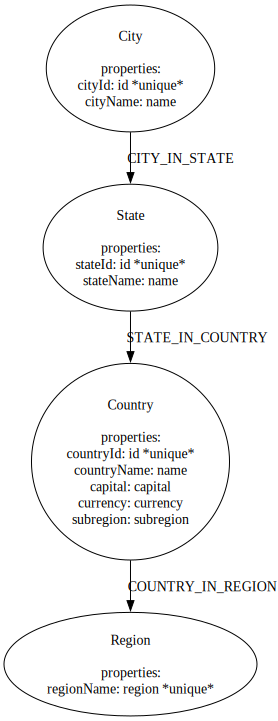

In [30]:
gdm.current_model.visualize()

In [31]:
corrections = "Create a node Currency with the unique property currency."

gdm.iterate_model(corrections=corrections)


 Please make corrections to the graph data model using the context provided. Here are the initial discovery findings:
### Summary of Insights for Graph Data Model

#### Unique Identifiers
1. **City ID**: Unique identifier for each city (from the cities dataset).
2. **State ID**: Unique identifier for each state (from the states dataset).
3. **Country ID**: Unique identifier for each country (from the countries dataset).

#### Significant Properties
- **City Name**: Name of the city.
- **State Name**: Name of the state.
- **Country Name**: Name of the country.
- **Capital**: Capital city of the country.
- **Currency**: Currency used in the country.
- **Region**: Broader geographical area the country belongs to.
- **Subregion**: Smaller geographical area within a region.

#### Possible Node Labels
1. **City**: Represents individual cities.
2. **State**: Represents states (subregions).
3. **Country**: Represents countries.
4. **Region**: Represents broader geographical regions.

#### Pos

DataModel(nodes=[Node(label='City', properties=[Property(name='cityId', type='str', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='cityName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='cities.csv'), Node(label='State', properties=[Property(name='stateId', type='str', column_mapping='id', alias='state_id', is_unique=True, part_of_key=False), Property(name='stateName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='states.csv'), Node(label='Country', properties=[Property(name='countryId', type='str', column_mapping='id', alias='country_id', is_unique=True, part_of_key=False), Property(name='countryName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='subregion', type='str', column_mappi

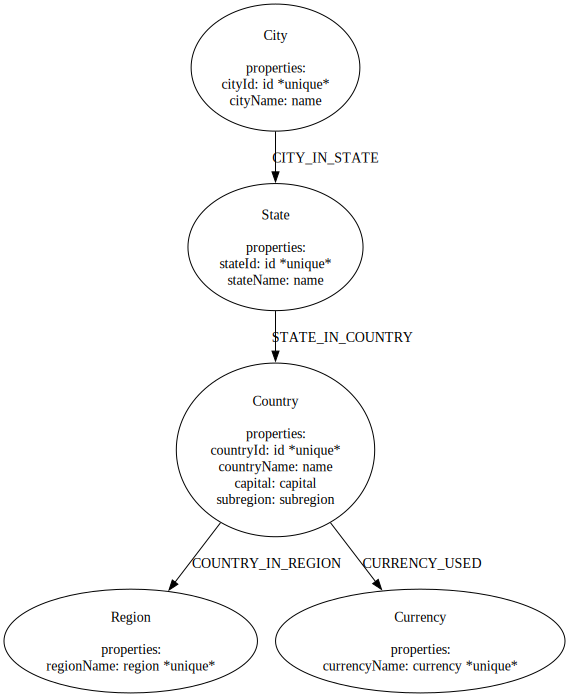

In [32]:
gdm.current_model.visualize()